<a href="https://colab.research.google.com/github/Mikhail-068/DronSolutiions-old/blob/master/DeepImageSearch_with_extract_colors_colorthief.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DeepImageSearch

In [ ]:
!pip install DeepImageSearch==1.4
!pip install colorthief
!pip install colorgram.py 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2
from colorthief import ColorThief
import matplotlib.pyplot as plt
from DeepImageSearch import LoadData, SearchImage, Index
import colorgram
import random

In [ ]:
path_dir = '/content/gdrive/MyDrive/selector_new_copy/Selector'

In [ ]:
list_dir = list(os.listdir(path_dir))

In [ ]:
path_shirt_men = '/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112'


In [ ]:
os.path.isdir(path_shirt_men)

True

In [ ]:
!cp -r /content/meta-data-files  /content/gdrive/MyDrive/meta-data-files 
#/content/gdrive/MyDrive/meta-data-files

In [ ]:
!cp -r /content/gdrive/MyDrive/meta-data-files /content/meta-data-files  

In [ ]:
image_list = LoadData().from_folder([path_shirt_men])

In [ ]:
print("Total Image Count:",len(image_list))
print("Samples:")
print(image_list[:10])

Total Image Count: 4079
Samples:
['/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112/762 (2).jpg', '/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112/761 (2).jpg', '/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112/765 (2).jpg', '/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112/764 (3).jpg', '/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112/762.jpg', '/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112/763.png', '/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112/766 (3).jpg', '/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112/759 (4).jpg', '/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112/766.jpg', '/content/gdrive/MyDrive/selector_new_copy/Selector/shirt men - 4 112/763 (2).jpg']


In [ ]:
Index(image_list).Start()

In [ ]:
# SearchImage().get_similar_images(image_path=image_list[0],number_of_images=5)

In [ ]:
# !rm -rf /content/meta-data-files

In [ ]:
#!rm -rf  /content/gdrive/MyDrive/meta-data-files

##SearchImageSort


In [ ]:
from io import BytesIO

def process_image(file_path):
    # Open the image and crop it
    img = cv2.imread(file_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_img = img[y:y + h, x:x + w]


    orig_width, orig_height, _ = img.shape
    cropped_width, cropped_height, _ = cropped_img.shape
    #
    # print("Размер оригинального изображения: {}x{}".format(orig_width, orig_height))
    # print("Размер обрезанного изображения: {}x{}".format(cropped_width, cropped_height))

    cropped_area = cropped_width * cropped_height
    orig_area = orig_width * orig_height

    percentage_cropped = round((cropped_area / orig_area) * 100, 2)
    # print("От оригинала  {:.2f}% изображения".format(percentage_cropped))
    
    
    img_bytes = cv2.imencode('.jpg', cropped_img)[1].tobytes()

    # Create a file-like buffer and return it
    buffer = BytesIO(img_bytes)
    buffer.seek(0)
    return buffer

In [ ]:
def cosine_distance(color1, color2):
    """
    Вычисляет косинусное расстояние между двумя цветами.
    """
    # color1 = color1/255
    # color2 = color2/255
    return 1 - np.dot(color1, color2) / (np.linalg.norm(color1) * np.linalg.norm(color2))


def color_distance(color1, color2, ord=np.inf):
    """
    
    Вычисляет евклидово расстояние между двумя цветами.
    """
    # color1 = color1 / 255
    # color2 = color2 / 255
    # color2 = np.array(color2)/255
    if ord == 3:
        return cosine_distance(color1, color2)
    return np.linalg.norm(color1 - color2, ord=ord)


def sort_colors_by_distance(color_list, query_color, ord=np.inf):
    """
     Сортирует массив цветов по близости к заданному цвету-запросу.
    """
    # Создаем массив расстояний между каждым цветом и запросом.
    distances = np.array([color_distance(color, query_color, ord=ord) for color in color_list])
    # Сортируем color_list по возрастанию расстояний.
    sorted_indices = np.argsort(distances)
    color_array = np.array(color_list)
    sorted_colors = color_array[sorted_indices]
    sorted_distances = distances[sorted_indices]
    return sorted_indices, sorted_distances


def display_images(image_paths_list):
    num_images = len(image_paths_list)
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 5))

    for i, ax in enumerate(axes):
        file_path = os.path.join(path_dir, image_paths_list[i])
        img = Image.open(file_path)
        img_arr = np.array(img)
        ax.imshow(img_arr)
        ax.axis('off')
    plt.show()


def get_color_images(image_paths, path_folder=path_dir):
    colors = []
    paths = []
    images = []
    for path in image_paths:
        # path = os.path.join(path_folder, path)
        file = process_image(path)
        color_thief = ColorThief(file)
        color_palette = color_thief.get_palette(color_count=3)
        # dominant_color = color_thief.get_color(quality=1)
        # color_palette.append(dominant_color)
        # color_palette.append(dominant_color)
        # color_palette.append(dominant_color)
        colors.append(np.array(color_palette).flatten())
        paths.append(path)

    # knn_model.fit(colors)

    return colors


def display_imag(image_, path_dir):
    file_path = os.path.join(path_dir, image_)
    img = Image.open(file_path)
    img_arr = np.array(img)
    plt.imshow(img_arr)
    plt.axis('off')
    plt.show()



In [ ]:
class MySearchImage(SearchImage):
    def get_sorted_similar_images(self, *args, show=True, **kwargs):
        parent_dict_result = self.get_similar_images(*args, **kwargs)

        query_vector = get_color_images([self.image_path])[0]
        # query_vector = extract_color(self.image_path)

        color_list = get_color_images(parent_dict_result.values())
        # color_list = [extract_color(path) for path in parent_dict_result.values()]

        sorted_indices, sorted_distances = sort_colors_by_distance(color_list, query_vector, ord=1)
        array_sort_colors = np.array(color_list)[sorted_indices]
        # sorted_lst = np.take(color_list, sorted_indices.tolist())
        # print(sorted_lst)
        # sorted_items = sorted(dict_result.items(), key=lambda x: sorted_indices.tolist())
        sorted_dict = {}
        for index in sorted_indices:
            key = list(parent_dict_result)[index]
            sorted_dict[key] = parent_dict_result[key]
        if show:
            print('*' * 100)
            print('DeepImageSearch')
            self.display_images_path(parent_dict_result.values(), array_sort_colors)
            print('*' * 100)
            print('Sort')
            self.display_images_path(sorted_dict.values(), array_sort_colors)
        return sorted_dict

    @staticmethod
    def display_images_path(image_paths_list, colors=None):
        num_images = len(image_paths_list)
        fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(20, 6))

        for ax, path, color_array in zip(axes, image_paths_list, colors):
            # загрузка изображения
            img = Image.open(path)
            img = img.resize((1000, 1000))
            width, height = img.size

            # создание изображения для цветов
            color_image = Image.new('RGB', (100, height), (255, 255, 255))
            draw = ImageDraw.Draw(color_image)

            # добавление цветов на изображение

            y = 0
            for color in color_array.reshape(-1, 3):
                draw.rectangle((0, y, 100, y + 20), fill=tuple(color.tolist()))
                y += 25

            # объединение двух изображений
            result = Image.new('RGB', (width + 100, height), (255, 255, 255))
            result.paste(img, (0, 0))
            result.paste(color_image, (width, 0))

            # отображение изображения
            ax.imshow(result)
            ax.axis('off')

        plt.show()

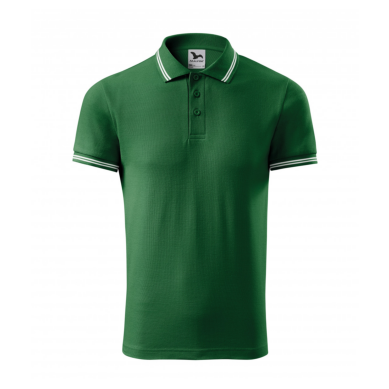

1/1 [==============================] - 1s 1s/step
****************************************************************************************************
DeepImageSearch


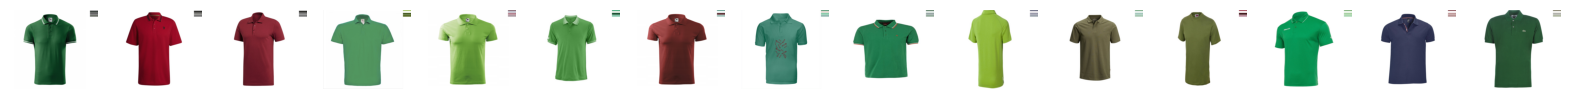

****************************************************************************************************
Sort


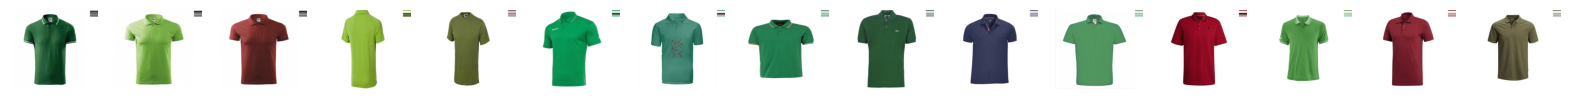

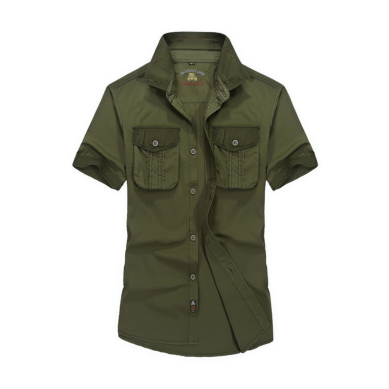

1/1 [==============================] - 1s 601ms/step
****************************************************************************************************
DeepImageSearch


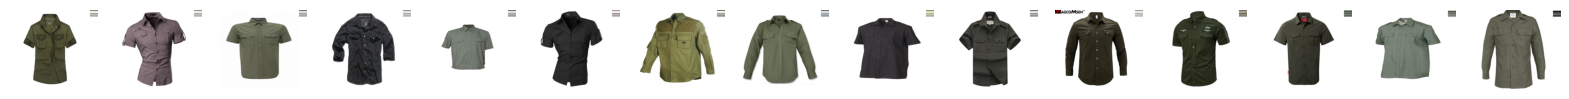

****************************************************************************************************
Sort


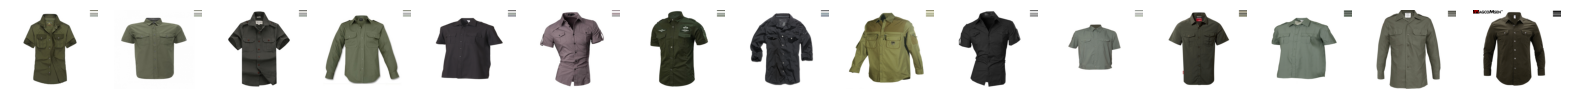

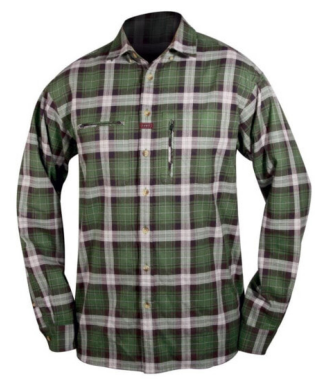

1/1 [==============================] - 0s 498ms/step
****************************************************************************************************
DeepImageSearch


In [ ]:
for i in range(10):
  n = random.randrange(len(image_list))
  display_imag(image_list[n], path_shirt_men)
  dict_result = MySearchImage().get_sorted_similar_images(os.path.join(path_shirt_men, image_list[n]), 15, show=True)
  print('\n')